Processing...


Using mean aggregation.
Using max aggregation.
Input features dimension: 165
Encoder input dimension: 495


Done!


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
Current alpha: 0.6000


Epoch 1: 0it [00:00, ?it/s]

Avg Loss: 6.995e+02, Avg Attribute Loss: 1.624e+01, Avg Structure Loss: 1.724e+03
Epoch 2/10
Current alpha: 0.5900


Epoch 2: 0it [00:00, ?it/s]

Avg Loss: 8.073e+01, Avg Attribute Loss: 1.502e+01, Avg Structure Loss: 1.753e+02
Epoch 3/10
Current alpha: 0.5800


Epoch 3: 0it [00:00, ?it/s]

Avg Loss: 2.434e+01, Avg Attribute Loss: 1.486e+01, Avg Structure Loss: 3.743e+01
Epoch 4/10
Current alpha: 0.5700


Epoch 4: 0it [00:00, ?it/s]

Avg Loss: 1.196e+01, Avg Attribute Loss: 1.483e+01, Avg Structure Loss: 8.157e+00
Epoch 5/10
Current alpha: 0.5600


Epoch 5: 0it [00:00, ?it/s]

Avg Loss: 9.036e+00, Avg Attribute Loss: 1.476e+01, Avg Structure Loss: 1.746e+00
Epoch 6/10
Current alpha: 0.5500


Epoch 6: 0it [00:00, ?it/s]

Avg Loss: 8.335e+00, Avg Attribute Loss: 1.472e+01, Avg Structure Loss: 5.243e-01
Epoch 7/10
Current alpha: 0.5400


Epoch 7: 0it [00:00, ?it/s]

Avg Loss: 8.058e+00, Avg Attribute Loss: 1.471e+01, Avg Structure Loss: 2.439e-01
Epoch 8/10
Current alpha: 0.5300


Epoch 8: 0it [00:00, ?it/s]

Avg Loss: 7.861e+00, Avg Attribute Loss: 1.468e+01, Avg Structure Loss: 1.661e-01
Epoch 9/10
Current alpha: 0.5200


Epoch 9: 0it [00:00, ?it/s]

Avg Loss: 7.674e+00, Avg Attribute Loss: 1.462e+01, Avg Structure Loss: 1.483e-01
Epoch 10/10
Current alpha: 0.5100


Epoch 10: 0it [00:00, ?it/s]

Avg Loss: 7.485e+00, Avg Attribute Loss: 1.455e+01, Avg Structure Loss: 1.291e-01


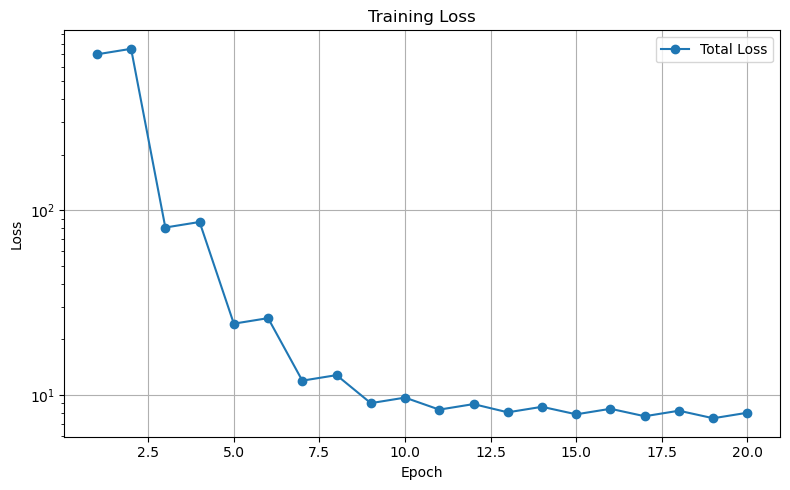

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import EllipticBitcoinDataset
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_dense_adj
from dominant import DOMINANTAugmented  # need DOMINANTBase because DOMINANT doesn't like mini-batching
from tqdm.notebook import tqdm  #  
import datetime

# Load data
dataset = EllipticBitcoinDataset(root='data/elliptic', force_reload=True)

data = dataset[0] # Need to index in because  team-pyg couldnt figure out a less dumb way to load the dataset

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# yo dude, here are hyperparameters for you to play with.
dropout = 0.1
use_interpolation = True
use_perturbation = True
interpolation_rate = 0.1
feature_noise = 0.05
structure_noise = 0.05
use_adaptive_alpha = True
start_alpha=0.6
end_alpha=0.5
use_aggregation = True
aggregation_mean = True
aggregation_max = True

loader = NeighborLoader(data, batch_size=2048, # we can experiment with different batch sizes too :) 
                        shuffle=True, num_neighbors=[10, 10], input_nodes=data.train_mask) # I think this ithe right way. Should investigate the math. 
model = DOMINANTAugmented(dropout=dropout,
                        use_interpolation=use_interpolation,
                        use_perturbation=use_perturbation,
                        interpolation_rate=interpolation_rate,
                        feature_noise=feature_noise,
                        structure_noise=structure_noise,
                        use_adaptive_alpha=use_adaptive_alpha,
                        alpha=start_alpha,
                        use_aggregation=use_aggregation,
                        aggregation_mean=aggregation_mean,
                        aggregation_max=aggregation_max,
                        end_alpha=end_alpha,in_dim=data.num_node_features).to(device) # HERE'S SOME TUNING OPTIONS FOR YA <3 - Eric
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Let's also experiment with different learning rates.
num_epochs = 10
loss_history = []
attr_loss_history = []
struct_loss_history = []
alpha_history = []

# Training loop
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss = 0
    total_attr_loss = 0
    total_struct_loss = 0


    if model.use_adaptive_alpha:
        current_alpha = model.update_alpha(epoch, num_epochs)
        print(f"Current alpha: {current_alpha:.4f}")
    else:
        current_alpha = model.current_alpha

    for i, batch in tqdm(enumerate(loader), desc=f"Epoch {epoch+1}", leave=True):
        batch = batch.to(device)
        x = batch.x
        edge_index = batch.edge_index
        batch_size = getattr(batch, 'batch_size', x.size(0))

        optimizer.zero_grad()
        x_hat, s_hat = model(x, edge_index, apply_augmentation=True)
        s = to_dense_adj(edge_index)[0].to(device)

        if model.use_aggregation:
            loss_matrix = model.compute_loss(x[:batch_size],  # Original features
                    x_hat[:batch_size],  # Reconstructed features
                    s[:batch_size, :batch_size],  # Original structure
                    s_hat[:batch_size, :batch_size]  # Reconstructed structure
                )
            # essentially we want to ensure consistent dimensionality across our original and reconstructed matrices
            # for features and for structure
            # the :batchsize limits makes sure we're calculating loss on the same subset of nodes

        loss_matrix = model.compute_loss(
            x[:batch_size], 
            x_hat[:batch_size],
            s[:batch_size, :], 
            s_hat[:batch_size]
        ) 
        
        loss = torch.mean(loss_matrix) # batchwise mean for calculating the gradient

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # gradient clipping - eric
        optimizer.step()

        total_loss += loss.item()  # but it gets summed for record keeping

        with torch.no_grad(): # since we're just updating the loss scorekeeping. we might want to graph this later in reporting.
            # Attribute loss 
            attr_matrix = model.loss_func(
                x[:batch_size], 
                x_hat[:batch_size],
                s[:batch_size, :], 
                s_hat[:batch_size],
                weight=1.0, #  from the docstring: `Balancing weight... between 0 and 1 inclusive between node feature and graph structure.`
                # logically, it's set to 1.0 here because we want to calculate the attribute loss
                # below, we will set it to 0 to calculate the structure loss
                pos_weight_a=model.pos_weight_a,
                pos_weight_s=model.pos_weight_s,
                bce_s=model.bce_s
            )
            attr_loss = torch.mean(attr_matrix).item()
            total_attr_loss += attr_loss
            
            # Structure loss 
            struct_matrix = model.loss_func(
                x[:batch_size], 
                x_hat[:batch_size],
                s[:batch_size, :], 
                s_hat[:batch_size],
                weight=0.0,
                pos_weight_a=model.pos_weight_a,
                pos_weight_s=model.pos_weight_s,
                bce_s=model.bce_s
            )
            struct_loss = torch.mean(struct_matrix).item()
            total_struct_loss += struct_loss
        

    batch_count = i + 1  # Total number of batches
    avg_loss = total_loss / batch_count
    avg_attr_loss = total_attr_loss / batch_count
    avg_struct_loss = total_struct_loss / batch_count
    print(f"Avg Loss: {avg_loss:.3e}, "
          f"Avg Attribute Loss: {avg_attr_loss:.3e}, "
          f"Avg Structure Loss: {avg_struct_loss:.3e}")
    
    # Record losses
    loss_history.append(avg_loss)
    attr_loss_history.append(avg_attr_loss)
    struct_loss_history.append(avg_struct_loss)
    alpha_history.append(current_alpha)

    avg_loss = total_loss / i # and then divided so that it's reflective of the full graph
    loss_history.append(avg_loss)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_history)+1), loss_history, 'o-', label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log') # log scale for better visibility
plt.title('Training Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
now = datetime.datetime.now()
formatted_now = now.strftime("%Y-%m-%d_%H_%M")
plt.savefig(f"loss_plot_{formatted_now}.png")
plt.show()